In [1]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cmasher as cmr

import synthesizer
from synthesizer.grid import Grid
from synthesizer.load_data.load_scsam import load_SCSAM

from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
)

from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles, Gas

from unyt import Msun, yr, Mpc, angstrom

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [ ]:
# Define the grid

grid_dir = '/mnt/ceph/users/snewman/grids'
grid_name = 'qsosed_bigger.hdf5'
grid_sps_name = 'bpass-2.2.1-bin_bpl-0.1,1.0,300.0-1.3,2.35.hdf5'

# Define a single, desired output wavelength array (e.g., 10000 points from 10 A to 1,000,000 A)
desired_lams = np.logspace(0.1, 6, 100000) * angstrom

grid_agn = Grid(grid_dir=grid_dir, grid_name=grid_name, ignore_lines=True, new_lam=desired_lams)
grid_sps = Grid(grid_dir=grid_dir, grid_name=grid_sps_name, ignore_lines=True, new_lam=desired_lams)

/mnt/home/snewman/myenv/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [3]:
# Load data from SC-SAM

sv = "0_0_0"

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_forestmgmt_fidSAM'

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as file:

        # Load properties
        bh_mass_sub = file[f'{sv}/Galprop/GalpropMBH'][:] * 1e9
        bh_mdot_sub = file[f'{sv}/Galprop/GalpropMaccdot_bright'][:]
        star_mass_sub = file[f'{sv}/Galprop/GalpropMstar'][:] * 1e9

        sfh = file[f'{sv}/Histprop/HistpropSFH'][:]
        z_hist = file[f'{sv}/Histprop/HistpropZt'][:]

        to_gal_prop = file[f'{sv}/Linkprop/LinkproptoGalprop'][:]
        redshift = file[f'{sv}/Linkprop/LinkpropRedshift'][:]

        sfh_t_bins = file[f'{sv}/Header/SFH_tbins'][:]

        # Align galaxy properties using mapping
        bh_mass = bh_mass_sub[to_gal_prop]
        bh_mdot = bh_mdot_sub[to_gal_prop]
        star_mass = star_mass_sub[to_gal_prop]

# Apply BH mass cut (M_BH > 1e6)
mass_cut = bh_mass > 1e6

bh_mass = bh_mass[mass_cut]
bh_mdot = bh_mdot[mass_cut]
star_mass = star_mass[mass_cut]
redshift = redshift[mass_cut]
sfh = sfh[mass_cut]
z_hist = z_hist[mass_cut]

print(sfh.shape) # (141636, 1405)
print(sfh_t_bins.shape) # (1405,)
print(len(bh_mass)) # 141636 (n gals)


(92016, 1405)
(1405,)
92016


In [4]:
def load_SCSAM_particle_galaxy(SFH, age_lst, Z_hist, bh_mass, bh_mdot, z, verbose=False):
    """Treat each age bin as a particle, using metallicity history."""

    # First load SFH data

    p_imass = []  # initial mass
    p_age = []    # age
    p_Z = []      # metallicity

    age_len = len(age_lst)

    if verbose:
        print("Iterating through SFH bins...")

    for age_ind in range(age_len):
        # Check if all SFH values in the slice are zero
        if (SFH[age_ind] == 0).all():
            continue
        p_imass.append(SFH[age_ind])       # 10^9 Msun
        p_age.append(age_lst[age_ind])     # Gyr
        p_Z.append(Z_hist[age_ind])        # unitless (Zsun)

    # Convert units
    p_imass = np.array(p_imass) * 1e9  # Msun
    p_age = np.array(p_age) * 1e9      # yr
    p_Z = np.array(p_Z)

    # Create stars object
    stars = ParticleStars(
        initial_masses=p_imass * Msun, ages=p_age * yr, metallicities=p_Z
    )

    print('nstars = ', len(p_imass))

    # Add black hole properties

    black_holes=BlackHoles(
            masses=np.array([bh_mass]) * Msun,
            accretion_rates=np.array([bh_mdot]) * Msun/yr,
            #coordinates=bh_pos * Mpc,
            redshift=np.array([z])
        )
    
    # Add gas properties 

    # Build galaxy
    return ParticleGalaxy(stars=stars,
                          black_holes=black_holes)

In [8]:
# How many galaxies to load
N = 10

# For my actual code use all galaxies in the subvolume

# Load galaxies with particle method

# Random indices from n galaxies
indices = np.random.choice(len(bh_mass), size=N, replace=False)

gals = []
seds = []

for i in indices:

    gal = load_SCSAM_particle_galaxy(SFH=sfh[i],
                                    age_lst=sfh_t_bins,
                                    Z_hist=z_hist[i],
                                    bh_mass=bh_mass[i],
                                    bh_mdot=bh_mdot[i],
                                    z=redshift[i],
                                    verbose=False)
    
    gals.append(gal)

    # Extract SED

    # Define emission model 
    
    stellar_incident = StellarEmissionModel(
    "stellar_incident",
    grid=grid_sps,
    extract="incident",
    fesc=0.3,
    )

    agn_incident = BlackHoleEmissionModel(
        "agn_incident",
        grid=grid_agn,
        extract="incident",
        fesc=0.3,
    )

    combined_emission = GalaxyEmissionModel(
        "total",
        combine=(stellar_incident, agn_incident)
    )

    #combined_emission.set_per_particle(True)
    #combined_emission.plot_emission_tree()

    spectra_type = "total"  # could be "incident", "nebular", "intrinsic", etc.
    
    gal.get_spectra(combined_emission, verbose=True)
    sed = gal.spectra[spectra_type]
    seds.append((sed.lam, sed.lnu))

nstars =  1085
[Python] Applying model overrides took: 0.000006 seconds
[Python] Getting the mask took: 0.000001 seconds
[Python] Setting up the Extractor (including grid axis extraction) took: 0.003917 seconds
[Python] Getting the extractor took: 0.003948 seconds
[Python] Preparing particle data for extraction took: 0.000061 seconds
[Python] Setting up integrated lnu calculation took: 0.000073 seconds
[C] Constructing C++ grid properties took: 0.000000 seconds
[C] Constructing C++ Particles object took: 0.000000 seconds
[C] Cloud in Cell weight loop took: 0.000067 seconds
[C] Compute integrated spectra from weights took: 0.053061 seconds
[C] Compute integrated SED took: 0.053156 seconds
[Python] Creating Sed took: 0.000156 seconds
[Python] Getting the mask took: 0.000001 seconds
[Python] Setting up the Extractor (including grid axis extraction) took: 0.003121 seconds
[Python] Getting the extractor took: 0.003140 seconds
[Python] Preparing particle data for extraction took: 0.000141 se

/tmp/ipykernel_1722262/2143671837.py:47: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to
`None`
  return ParticleGalaxy(stars=stars,
/mnt/home/snewman/myenv/lib/python3.12/site-packages/synthesizer/emission_models/utils.py:89: RuntimeWarning: divide by zero encountered in log10
  return np.log10(value)


[C] Compute integrated spectra from weights took: 0.032565 seconds
[C] Compute integrated SED took: 0.032588 seconds
[Python] Creating Sed took: 0.000126 seconds
[Python] Getting the mask took: 0.000001 seconds
[Python] Setting up the Extractor (including grid axis extraction) took: 0.000031 seconds
[Python] Getting the extractor took: 0.000046 seconds
[Python] Preparing particle data for extraction took: 0.000049 seconds
[Python] Setting up integrated lnu calculation took: 0.000057 seconds
[C] Constructing C++ grid properties took: 0.000000 seconds
[C] Constructing C++ Particles object took: 0.000000 seconds
[C] Cloud in Cell weight loop took: 0.000078 seconds
[C] Compute integrated spectra from weights took: 0.044241 seconds
[C] Compute integrated SED took: 0.044343 seconds
[Python] Creating Sed took: 0.000470 seconds
[Python] Creating Sed took: 0.000091 seconds
[Python] Generating all spectra took: 0.080029 seconds
nstars =  1243
[Python] Applying model overrides took: 0.000002 seco

/mnt/home/snewman/myenv/lib/python3.12/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


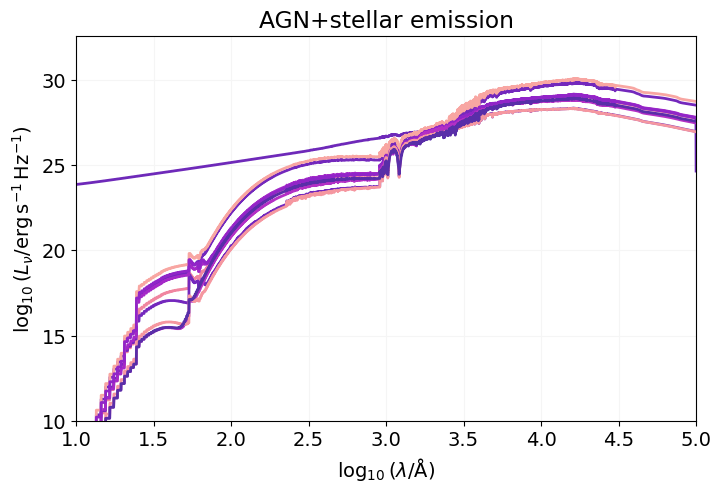

In [9]:
# Plot SEDs

# Choose a cmasher colormap, e.g., "cmr.rainforest"
cmap = cmr.get_sub_cmap("cmr.bubblegum", 0.05, 0.95)  # full range of the colormap

# Particle SEDs plotting
plt.figure(figsize=(8, 5))

for lam, lnu in seds:
    color = cmap(np.random.rand())  # pick a random color from the colormap
    plt.plot(np.log10(lam), np.log10(lnu), color=color, lw=2)

plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
plt.xlim(left=1, right=5)
plt.ylim(bottom=10)
plt.title('AGN+stellar emission')
plt.grid(color="whitesmoke")
plt.show()

In [10]:
print(gals[0].black_holes.accretion_rates)
print(gals[0].black_holes.masses)

[0.] Msun/yr
[20652700.] Msun


In [19]:
# Calculate the Eddington accretion rate
eddington_rate = gals[6].black_holes.calculate_accretion_rate_eddington()

print(eddington_rate)

[0.]
